### 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch 
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

In [3]:
df = pd.read_csv('C:/Users/chaeh/bigcon/dataset/0910 착과수_컬럼추가.csv') #착과수

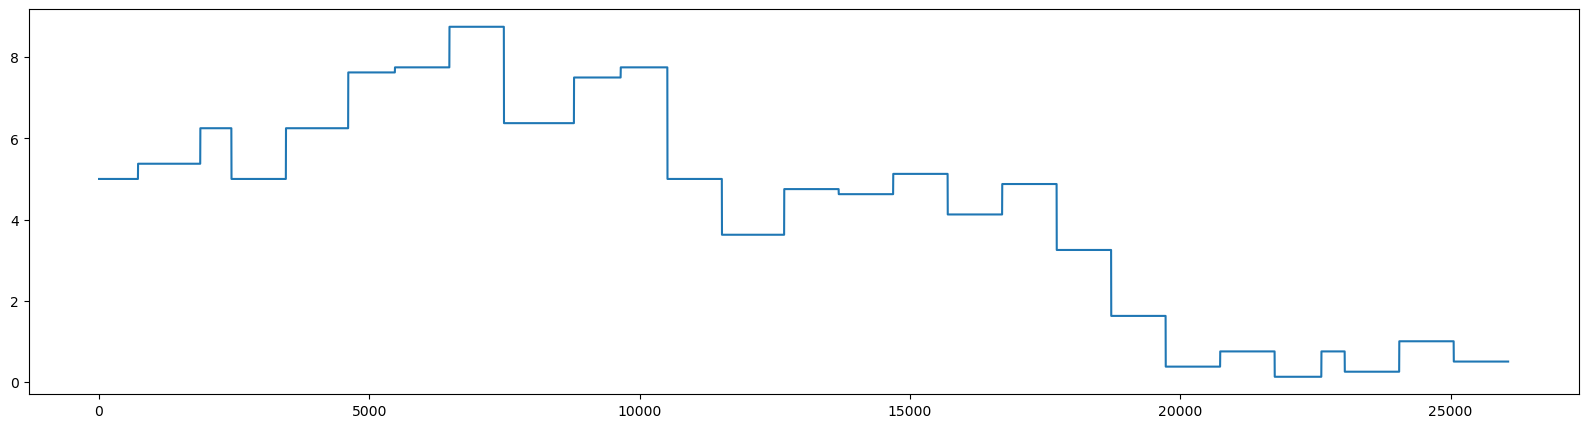

In [4]:
#착과수 추이
plt.figure(figsize=(20,5))
plt.plot(range(len(df)), df["FRST_TREE_CNT"])
plt.show()

In [5]:
df.head()

,STRG_DT,FRST_TREE_CNT,PFBS_NTRO_CBDX_CTRN,EXTN_TPRT,ABSLT_HMDT,EXTN_SRQT,WATER_LACK_VL,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,2022-01-01 0:00,5.0,456,-2.2,8.3,0,0.9,30.6,9.0,10.0,92.0,0,1.35
1,2022-01-01 0:10,5.0,459,-2.2,8.6,0,0.8,37.2,9.0,10.3,92.0,0,1.35
2,2022-01-01 0:20,5.0,468,-2.2,8.6,0,0.9,34.8,9.0,10.5,90.2,0,1.35
3,2022-01-01 0:30,5.0,466,-2.3,8.7,0,0.7,33.6,9.0,10.4,91.4,0,1.35
4,2022-01-01 0:40,5.0,467,-2.3,8.7,0,0.6,33.4,9.0,10.1,95.1,0,1.35


In [6]:
df = df.drop(columns=['EXTN_TPRT', 'ABSLT_HMDT', 'EXTN_SRQT', 'WATER_LACK_VL'])

In [7]:
df.shape

(26064, 9)

In [8]:
df.columns

Index(['STRG_DT', 'FRST_TREE_CNT', 'PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1',
       'HTNG_TPRT_1', 'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2',
       'SKLT_OPDR_RATE_1_RIGHT', 'GDD'],
      dtype='object')

In [9]:
torch.manual_seed(0) #학습을 다시 수행 시 실헙을 동일하게 진행하기 위해서 난수를 동일하게 생성

In [10]:
# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# 파라미터 초기화
seq_length = 144 #6*24 -> 하루 단위
data_dim = 8 #전체 feature 개수
hidden_dim = 256
output_dim = 1
learning_rate = 0.001 
epochs = 500
batch_size = 128

In [12]:
#학습 데이터 셋 생성
def make_dataset(data, seq_len):
    data_X = []
    data_Y = []
    
    #sequence 데이터 생성
    for i in range(len(data)-seq_len):
        x = data[i:i+seq_len, :] #0~143, 1~144, ...
        y = data[i+seq_len, [-1]] #0~143, 1~144, ...
        data_X.append(x)
        data_Y.append(y)
    
    return np.array(data_X), np.array(data_Y)

#필요한 컬럼만 선택
df = df[['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1', 'HTNG_TPRT_1',
       'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2', 'SKLT_OPDR_RATE_1_RIGHT', 'GDD', 'FRST_TREE_CNT']]

#train/test 분리
train_size = int(len(df)*0.8) #하반기 0.2
train_set = df[0:train_size]
test_set = df[train_size:] #train_size - seq_length

In [13]:
#scaling
train_set = train_set.copy() #deepcopy 원리
test_set = test_set.copy()

scaler_x = StandardScaler()
scaler_x.fit(train_set.iloc[:,:-1])

train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
test_set.iloc[:,:-1] = scaler_x.transform(test_set.iloc[:,:-1])

scaler_y = StandardScaler()
scaler_y.fit(train_set.iloc[:,[-1]])

train_set.iloc[:,-1] = scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:,-1] = scaler_y.transform(test_set.iloc[:,[-1]])

trainX, trainY = make_dataset(np.array(train_set), seq_length) #sequence 데이터로 생성
testX, testY = make_dataset(np.array(test_set), seq_length)

In [14]:
#사용하는 device로 적용, numpy를 tensor로 바꾸기 
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)

testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

#TensorDataset은 학습 데이터 X와 레이블 Y를 묶어 놓은 컨테이너
dataset = TensorDataset(trainX_tensor, trainY_tensor)

#DataLoader를 통해 배치 크기, 데이터를 섞을지 등을 결정한다.
#참고) drop_last: batch_size에 따라 마지막 batch의 길이가 달라질 수 있어서, 마지막 배치를 사용할지 여부
dataloader = DataLoader(dataset, batch_size = batch_size, 
                        shuffle = False, drop_last = True) 

### modeling

In [15]:
#LSTM 만들기

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers): 
        super(LSTMModel, self).__init__()
        
        self.output_dim = output_dim
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        #self.input_dim = input_dim
        
        #참고) batch_first: True이면 Output 값의 사이즈는 (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
    

    def reset_hidden_state(self):
        #hidden state 초기화 함수
        #매번 새로운 학습을 하여 최적의 값을 찾기 위해서 사용
        self.hidden = (
        torch.zeros(self.layers, self.seq_length, self.hidden_dim),
        torch.zeros(self.layers, self.seq_length, self.hidden_dim)
        )
        
        
    def forward(self,x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])

        return out

In [16]:
LSTM = LSTMModel(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)

In [17]:
#training
def train_LSTM(model, train_df, epochs, lr, verbose, patience):
    
    #손실함수 지정
    criterion = nn.MSELoss().to(device)
    
    #최적화
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    #에포크마다 loss 저장하기
    train_hist = np.zeros(epochs) #epoch 크기의 배열을 생성해 각 epoch마다 loss 저장
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            
            #seq별 hidden state reset
            model.reset_hidden_state()
            
            #h(x) 계산
            outputs = model(x_train)
            
            #cost 계산
            loss = criterion(outputs, y_train)
            
            #참고: 파이토치에서 역전파 수행 시 계속 값을 더해주기 때문에,
            #역전파 수행 전 gradients를 0으로 만들어주고 시작해야 한다.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
        train_hist[epoch] = avg_cost
        
        if epoch%verbose == 0:
            print("Epoch: ", "%04d" %(epoch),
                 'train loss: ', '{:.4f}'.format(avg_cost))
            
        #patience마다 early stopping 여부 확인
        #참고) early stopping: 더 이상 개선이 없으면 학습을 중단한다. overfitting 방지
        if (epoch%patience == 0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                break
                
    return model.eval(), train_hist

In [18]:
model, train_hist = train_LSTM(LSTM, dataloader, epochs = epochs, 
                               lr = learning_rate, verbose = 20, patience = 20)

Epoch:  0000 train loss:  0.2273
Epoch:  0020 train loss:  0.0023
Epoch:  0040 train loss:  0.0012
Epoch:  0060 train loss:  0.0015

 Early Stopping


In [19]:
with torch.no_grad(): #gradient 누적 방지 
    pred = []
    for i in range(len(testX_tensor)):
        model.reset_hidden_state()
        
        predicted = model(torch.unsqueeze(testX_tensor[i], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)
        
    #scaling 다시 원래대로 돌리기
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))    
    testY_inverse = scaler_y.inverse_transform(testY_tensor)    


#RMSE
rmse = mean_squared_error(testY_inverse, pred_inverse)**0.5
print('RMSE score: ', rmse)

RMSE score:  0.09887213868817861


In [20]:
pred_inverse

array([[0.96934248],
       [0.97057938],
       [0.96878535],
       ...,
       [0.53078186],
       [0.52729761],
       [0.52240796]])

In [21]:
testY_inverse

array([[0.74999989],
       [0.74999989],
       [0.74999989],
       ...,
       [0.49999999],
       [0.49999999],
       [0.49999999]])

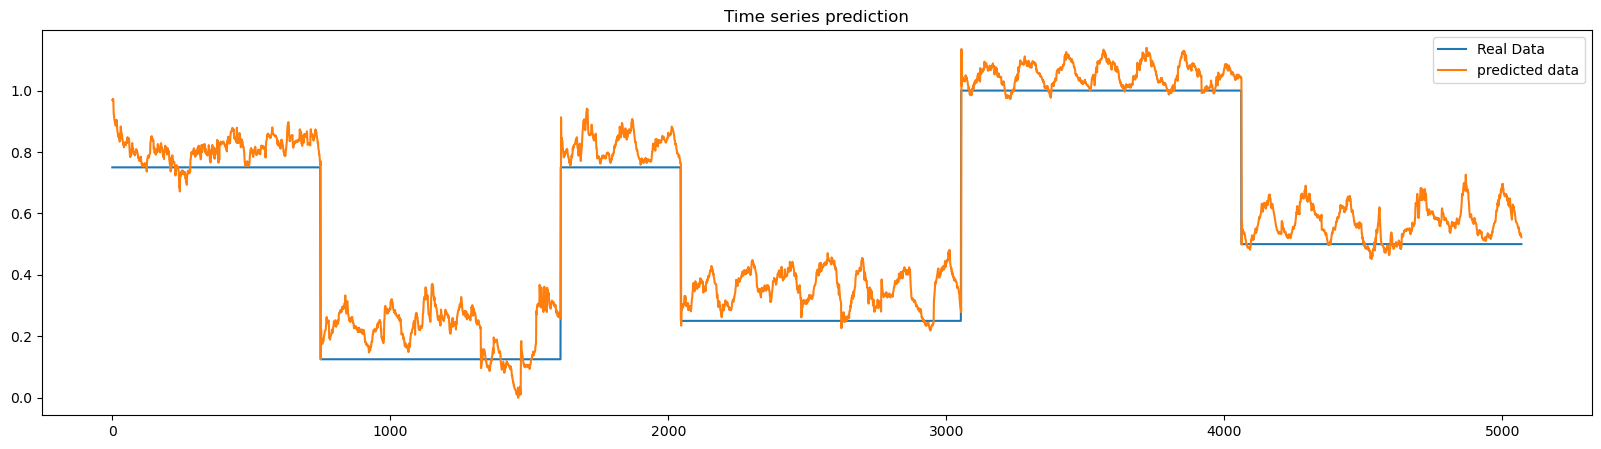

In [65]:
plt.figure(figsize = (20,5))
plt.plot(testY_inverse, label = 'Real Data')
plt.plot(pred_inverse, label = 'predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

저장

In [16]:
PATH = 'C:/Users/chaeh/bigcon/dataset/'

In [61]:
torch.save(LSTM, PATH + 'model.pt')  # 전체 모델 저장

In [17]:
#모델 불러오기 
loaded_model = torch.load(PATH + 'model.pt')

## 일별 평균

In [18]:
with torch.no_grad(): #gradient 누적 방지 
    pred = []
    for i in range(len(testX_tensor)):
        loaded_model.reset_hidden_state()
        
        predicted = loaded_model(torch.unsqueeze(testX_tensor[i], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)
        
    #scaling 다시 원래대로 돌리기
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))    
    testY_inverse = scaler_y.inverse_transform(testY_tensor)    


#RMSE
rmse = mean_squared_error(testY_inverse, pred_inverse)**0.5
print('RMSE score: ', rmse)

RMSE score:  0.09887212746424047


In [73]:
df = pd.read_csv('C:/Users/chaeh/bigcon/dataset/0910 착과수_컬럼추가.csv')
df

,STRG_DT,FRST_TREE_CNT,PFBS_NTRO_CBDX_CTRN,EXTN_TPRT,ABSLT_HMDT,EXTN_SRQT,WATER_LACK_VL,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,2022-01-01 0:00,5.0,456,-2.2,8.3,0,0.9,30.6,9.0,10.0,92.0,0,1.35
1,2022-01-01 0:10,5.0,459,-2.2,8.6,0,0.8,37.2,9.0,10.3,92.0,0,1.35
2,2022-01-01 0:20,5.0,468,-2.2,8.6,0,0.9,34.8,9.0,10.5,90.2,0,1.35
3,2022-01-01 0:30,5.0,466,-2.3,8.7,0,0.7,33.6,9.0,10.4,91.4,0,1.35
4,2022-01-01 0:40,5.0,467,-2.3,8.7,0,0.6,33.4,9.0,10.1,95.1,0,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,2022-06-30 23:10,0.5,421,25.3,22.8,0,2.0,25.6,0.0,29.6,91.1,40,-0.75
26060,2022-06-30 23:20,0.5,421,25.1,22.7,0,1.9,25.6,0.0,29.6,91.5,40,-0.75
26061,2022-06-30 23:30,0.5,423,24.9,22.5,0,2.0,25.7,0.0,29.6,91.8,40,-0.75
26062,2022-06-30 23:40,0.5,427,24.6,22.5,0,1.7,25.6,0.0,29.6,92.2,40,-0.75


In [74]:
df = df.drop(columns=['EXTN_TPRT', 'ABSLT_HMDT', 'EXTN_SRQT', 'WATER_LACK_VL'])

In [75]:
df1 = pd.DataFrame()

In [76]:
df1['STRG_DT'] = df.iloc[20995:, 0]

In [77]:
test_y_list = []
for i in range(len(testY_inverse)):
    test_y_list.append(testY_inverse[i][0])

In [78]:
pred_y_list = []
for i in range(len(pred_inverse)):
    pred_y_list.append(pred_inverse[i][0])

In [79]:
df1['test_y'] = test_y_list
df1['pred_y'] = pred_y_list

In [129]:
df1['PFBS_NTRO_CBDX_CTRN'] = df.iloc[20995:, 2]
df1['SPL_TPRT_1'] = df.iloc[20995:, 3]
df1['HTNG_TPRT_1'] = df.iloc[20995:, 4]
df1['SPL_TPRT_2'] = df.iloc[20995:, 5]
df1['AVE_INNER_HMDT_1_2'] = df.iloc[20995:, 6]
df1['SKLT_OPDR_RATE_1_RIGHT'] = df.iloc[20995:, 7]
df1['GDD'] = df.iloc[20995:, 8]

In [130]:
df1

,STRG_DT,test_y,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
20995,2022-05-26 19:10:00,0.75,0.969343,398,30.2,0.0,26.9,42.5,20,-0.45
20996,2022-05-26 19:20:00,0.75,0.970579,398,30.0,0.0,26.5,45.7,20,-0.45
20997,2022-05-26 19:30:00,0.75,0.968785,395,29.5,0.0,26.3,48.0,20,-0.45
20998,2022-05-26 19:40:00,0.75,0.972817,399,29.2,0.0,26.1,52.0,20,-0.45
20999,2022-05-26 19:50:00,0.75,0.960577,403,29.0,0.0,25.8,55.7,40,-0.45
...,...,...,...,...,...,...,...,...,...,...
26059,2022-06-30 23:10:00,0.50,0.535846,421,25.6,0.0,29.6,91.1,40,-0.75
26060,2022-06-30 23:20:00,0.50,0.530907,421,25.6,0.0,29.6,91.5,40,-0.75
26061,2022-06-30 23:30:00,0.50,0.530782,423,25.7,0.0,29.6,91.8,40,-0.75
26062,2022-06-30 23:40:00,0.50,0.527298,427,25.6,0.0,29.6,92.2,40,-0.75


In [131]:
df1.to_csv("C:/Users/chaeh/bigcon/dataset/0926 예측 값1.csv", index = False)

In [81]:
df2 = pd.DataFrame()

In [82]:
df1['STRG_DT'] = pd.to_datetime(df1['STRG_DT'])

In [83]:
true_y_mean = df1.groupby(df1['STRG_DT'].dt.date)['test_y'].mean()
true_y_mean

STRG_DT
2022-05-26    0.750
2022-05-27    0.750
2022-05-28    0.750
2022-05-29    0.750
2022-05-30    0.750
2022-05-31    0.750
2022-06-01    0.125
2022-06-02    0.125
2022-06-03    0.125
2022-06-04    0.125
2022-06-05    0.125
2022-06-06    0.125
2022-06-07    0.750
2022-06-08    0.750
2022-06-09    0.750
2022-06-10    0.250
2022-06-11    0.250
2022-06-12    0.250
2022-06-13    0.250
2022-06-14    0.250
2022-06-15    0.250
2022-06-16    0.250
2022-06-17    1.000
2022-06-18    1.000
2022-06-19    1.000
2022-06-20    1.000
2022-06-21    1.000
2022-06-22    1.000
2022-06-23    1.000
2022-06-24    0.500
2022-06-25    0.500
2022-06-26    0.500
2022-06-27    0.500
2022-06-28    0.500
2022-06-29    0.500
2022-06-30    0.500
Name: test_y, dtype: float64

In [84]:
pred_y_mean = df1.groupby(df1['STRG_DT'].dt.date)['pred_y'].mean()
pred_y_mean

STRG_DT
2022-05-26    0.893380
2022-05-27    0.804125
2022-05-28    0.768302
2022-05-29    0.821833
2022-05-30    0.815965
2022-05-31    0.838223
2022-06-01    0.246348
2022-06-02    0.234596
2022-06-03    0.252308
2022-06-04    0.263339
2022-06-05    0.105325
2022-06-06    0.232323
2022-06-07    0.823778
2022-06-08    0.826209
2022-06-09    0.815661
2022-06-10    0.351247
2022-06-11    0.360946
2022-06-12    0.380513
2022-06-13    0.381638
2022-06-14    0.333763
2022-06-15    0.354412
2022-06-16    0.348385
2022-06-17    1.042988
2022-06-18    1.049075
2022-06-19    1.054176
2022-06-20    1.063576
2022-06-21    1.059379
2022-06-22    1.055732
2022-06-23    1.036496
2022-06-24    0.570026
2022-06-25    0.595001
2022-06-26    0.574869
2022-06-27    0.501431
2022-06-28    0.591130
2022-06-29    0.590416
2022-06-30    0.587641
Name: pred_y, dtype: float64

In [85]:
pred_y_mean.index

Index([2022-05-26, 2022-05-27, 2022-05-28, 2022-05-29, 2022-05-30, 2022-05-31,
       2022-06-01, 2022-06-02, 2022-06-03, 2022-06-04, 2022-06-05, 2022-06-06,
       2022-06-07, 2022-06-08, 2022-06-09, 2022-06-10, 2022-06-11, 2022-06-12,
       2022-06-13, 2022-06-14, 2022-06-15, 2022-06-16, 2022-06-17, 2022-06-18,
       2022-06-19, 2022-06-20, 2022-06-21, 2022-06-22, 2022-06-23, 2022-06-24,
       2022-06-25, 2022-06-26, 2022-06-27, 2022-06-28, 2022-06-29, 2022-06-30],
      dtype='object', name='STRG_DT')

In [86]:
true_list = []
for i in true_y_mean:
    true_list.append(round(i,4))

In [87]:
pred_list = []
for i in pred_y_mean:
    pred_list.append(i)

In [88]:
df2['true_value'] = true_list
df2['pred_value'] = pred_list
df2

,true_value,pred_value
0,0.750,0.893380
1,0.750,0.804125
2,0.750,0.768302
3,0.750,0.821833
4,0.750,0.815965
5,0.750,0.838223
6,0.125,0.246348
7,0.125,0.234596
8,0.125,0.252308
9,0.125,0.263339


In [89]:
df2['date'] = pred_y_mean.index

In [58]:
df2.set_index('date', inplace=True)
df2

,true_value,pred_value
date,,
2022-05-26,0.750,0.893380
2022-05-27,0.750,0.804125
2022-05-28,0.750,0.768302
2022-05-29,0.750,0.821833
2022-05-30,0.750,0.815965
2022-05-31,0.750,0.838223
2022-06-01,0.125,0.246348
2022-06-02,0.125,0.234596
2022-06-03,0.125,0.252308


In [132]:
#RMSE
rmse = mean_squared_error(df2['true_value'], df2['pred_value'])**0.5
print('RMSE score: ', rmse)

RMSE score:  0.08788884738082083


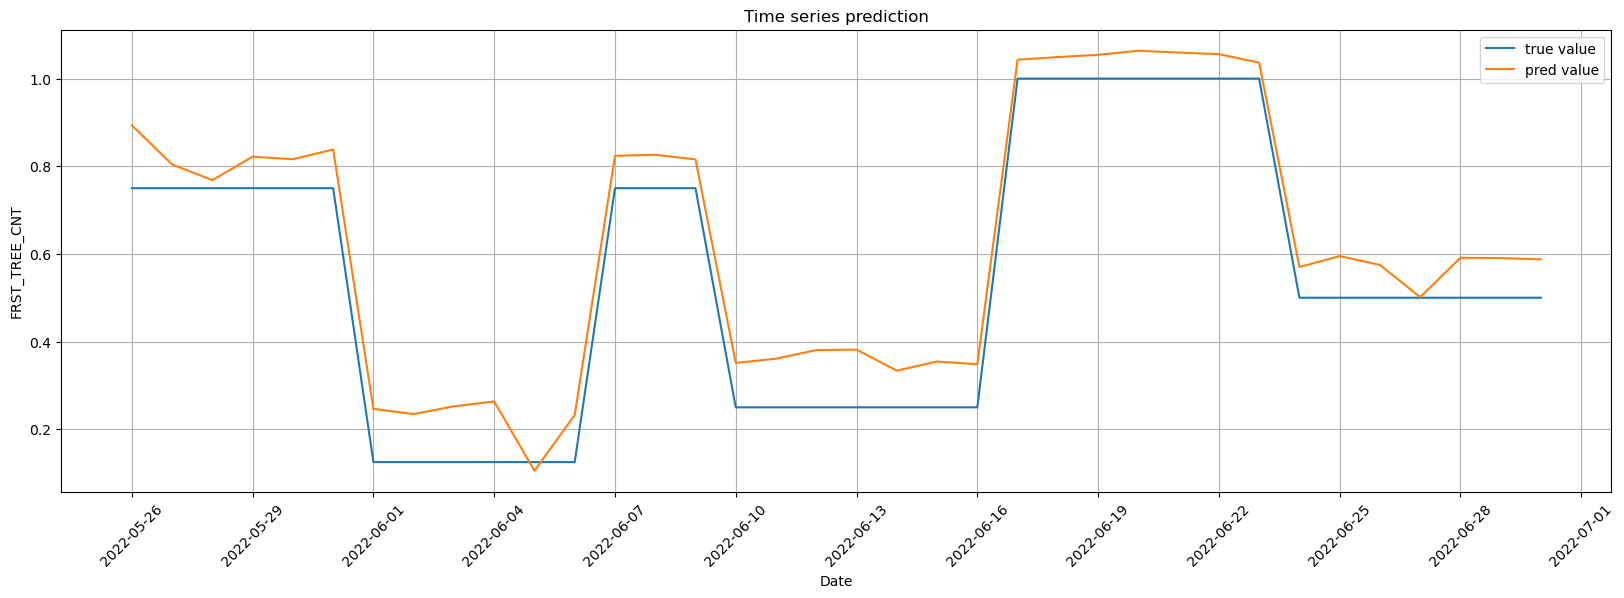

In [102]:
# 날짜 열을 날짜 형식으로 변환
df2['date'] = pd.to_datetime(df2['date'])

# 그래프 그리기
plt.figure(figsize=(20, 6))
plt.plot(df2['date'], df2['true_value'], label='true value')
plt.plot(df2['date'], df2['pred_value'], label='pred value')
plt.xlabel('Date')
plt.ylabel('FRST_TREE_CNT')
plt.title('Time series prediction')
plt.legend()
plt.xticks(rotation=45) 
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(14))  
plt.grid()
plt.show()

---

## XAI
- 결과에 반영하지는 않았습니다.

### lime
- LIME doesn't seem to be fitting for any regression based recurrent models.

In [133]:
import shap
import tqdm
import lime
import torch.nn.functional as F

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [134]:
df

,STRG_DT,FRST_TREE_CNT,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,2022-01-01 0:00,5.0,456,30.6,9.0,10.0,92.0,0,1.35
1,2022-01-01 0:10,5.0,459,37.2,9.0,10.3,92.0,0,1.35
2,2022-01-01 0:20,5.0,468,34.8,9.0,10.5,90.2,0,1.35
3,2022-01-01 0:30,5.0,466,33.6,9.0,10.4,91.4,0,1.35
4,2022-01-01 0:40,5.0,467,33.4,9.0,10.1,95.1,0,1.35
...,...,...,...,...,...,...,...,...,...
26059,2022-06-30 23:10,0.5,421,25.6,0.0,29.6,91.1,40,-0.75
26060,2022-06-30 23:20,0.5,421,25.6,0.0,29.6,91.5,40,-0.75
26061,2022-06-30 23:30,0.5,423,25.7,0.0,29.6,91.8,40,-0.75
26062,2022-06-30 23:40,0.5,427,25.6,0.0,29.6,92.2,40,-0.75


In [135]:
features = ['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1', 'HTNG_TPRT_1',
       'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2', 'SKLT_OPDR_RATE_1_RIGHT', 'GDD', 'FRST_TREE_CNT']

In [136]:
lime_explainer = lime.lime_tabular.RecurrentTabularExplainer(trainX, feature_names=features,
                                                            discretize_continuous=True, discretizer='decile') 

In [137]:
def pred1(input_data):
    input_data = torch.FloatTensor(input_data).to(device)

    with torch.no_grad(): # gradient 누적 방지 
        predictions = []

        for i in range(len(input_data)):
            loaded_model.reset_hidden_state()
            
            # 각 데이터 포인트에 대한 예측 계산
            predicted = loaded_model(torch.unsqueeze(input_data[i], 0))
            
            # 예측값을 확률로 변환 (softmax 함수 사용)
            probabilities = torch.softmax(predicted, dim=1)
            
            # 확률값 리스트로 저장
            probabilities = probabilities.squeeze().cpu().numpy()
            predictions.append(probabilities)

    return np.array(predictions)

In [138]:
lime_explanations = lime_explainer.explain_instance(testX[50], pred1, num_features=8)

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

- 결과를 보면 알 수 있듯이, 해당 값을 예측할 확률 스코어가 필요하기 때문에 time series 데이터의 회귀 예측에는 적합하지 않다. 

### SHAP
- LSTM 모델에 대한 pytorch 지원이 안됨

In [139]:
#TensorDataset은 학습 데이터 X와 레이블 Y를 묶어 놓은 컨테이너
dataset_test = TensorDataset(testX_tensor, testY_tensor)

#DataLoader를 통해 배치 크기, 데이터를 섞을지 등을 결정한다.
#참고) drop_last: batch_size에 따라 마지막 batch의 길이가 달라질 수 있어서, 마지막 배치를 사용할지 여부
dataloader_test = DataLoader(dataset_test, batch_size = batch_size, 
                        shuffle = False, drop_last = True) 

In [140]:
batch = next(iter(dataloader_test))

In [141]:
data_list, _ = batch #images -> data_list

In [142]:
background = data_list[:100]
test_data_list = data_list[100:110]

e = shap.DeepExplainer(loaded_model, data_list)
shap_values = e.shap_values(test_data_list)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
